<h1><center>Batch-Нормализация и Dropout</center></h1>

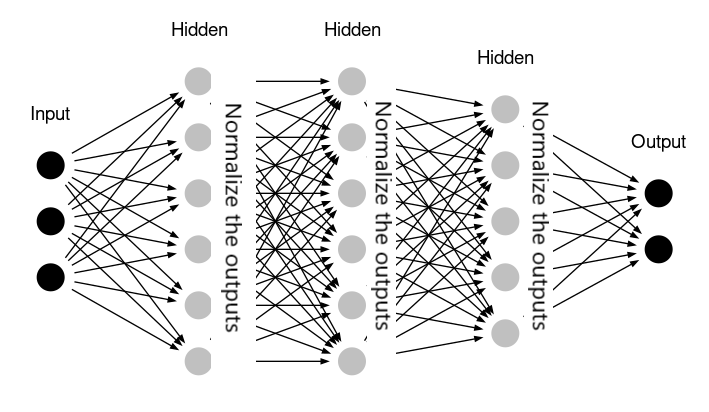

# 1. Зачем нормализовывать входные данные?

Прежде чем обсуждать пакетную нормализацию, мы узнаем, почему нормализация входных данных ускоряет обучение нейронной сети.

Рассмотрим сценарий, в котором 2D-данные с функциями x_1 и x_2 поступают в нейронную сеть. Одна из этих функций x_1 имеет более широкий спред от -200 до 200, а другая функция x_2 имеет более узкий спред от -10 до 10.

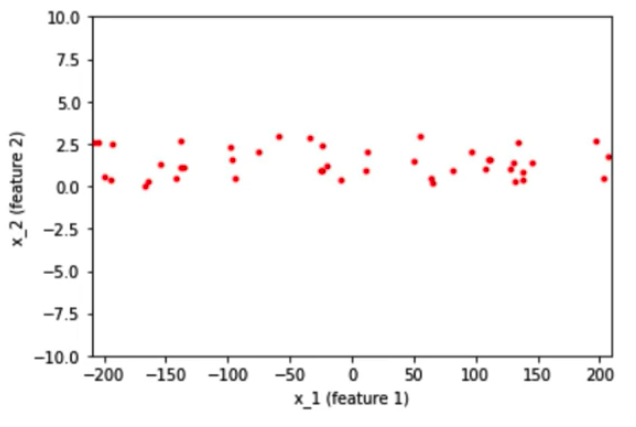

После того, как мы нормализовали данные, разброс данных для обеих функций сконцентрирован в одном регионе, то есть… от -2 до 2. Разброс будет выглядеть следующим образом:

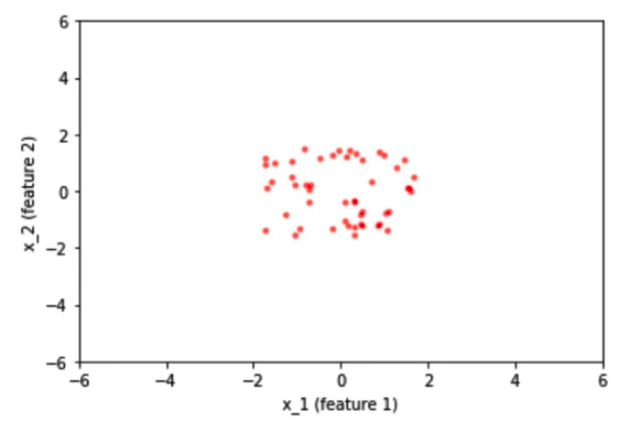

До того, как мы нормализовали входные данные, веса, связанные с этими входами, сильно различались бы, потому что входные характеристики представлены в разных диапазонах от -200 до 200 и от -2 до 2. Чтобы учесть разницу в диапазоне между функциями, некоторые веса должны были быть большими, а некоторые должны быть маленькими. Если у нас есть большие веса, то обновления, связанные с обратным распространением, также будут большими, и наоборот. Из-за этого неравномерного распределения весов для входных данных алгоритм обучения продолжает колебаться в области плато, прежде чем он найдет глобальные минимумы.

Чтобы алгоритм обучения не тратил много времени на колебания на плато, мы нормализуем входные характеристики так, чтобы все функции были в одном масштабе. Поскольку наши входные данные находятся в одной шкале, веса, связанные с ними, также будут в одной шкале. Таким образом нормализация помогает сети быстрее обучаться.

# 2. Пакетная нормализация. Batch Normalization

Мы нормализовали входные данные, но как насчет скрытого представления?

Нормализуя входные данные, мы можем привести все входные функции к одному и тому же масштабу. В нейронной сети нам нужно вычислить предварительную активацию для первого нейрона первого слоя a₁₁. Мы знаем, что предварительная активация - это не что иное, как взвешенная сумма входов плюс смещение. Другими словами, это скалярное произведение между первой строкой весовой матрицы W₁ и входной матрицей X плюс смещение b₁₁.

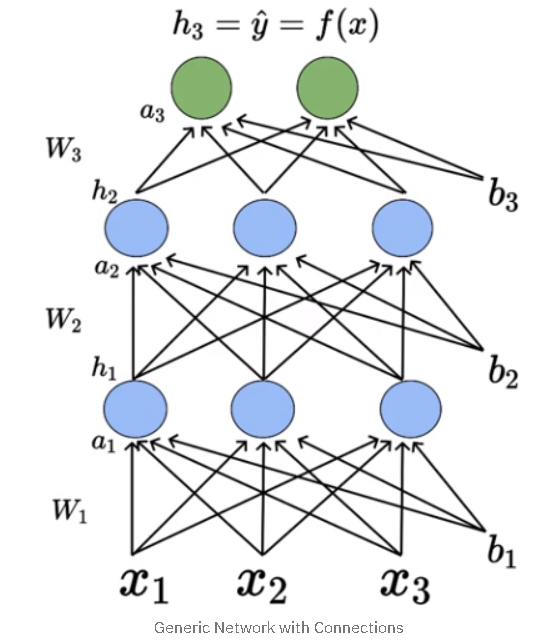

Математическое уравнение для предварительной активации на каждом слое i выражается следующим образом:

$$a_i = W_ix + b_i$$

Активация на каждом слое равна применению функции активации к выходу предварительной активации этого слоя. Математическое уравнение для активации на каждом слое i задается следующим образом:

$$h_i(x) = g(a_i(x))$$

Где g - функция активации.

Точно так же необходимо вычислить значения активации для n количества скрытых слоев, присутствующих в сети. Значения активации будут действовать как входные данные для следующих скрытых слоев, присутствующих в сети. поэтому не имеет значения, что мы сделали с входными данными, нормализовали мы их или нет, значения активации будут сильно различаться по мере того, как мы все глубже и глубже проникаем в сеть в зависимости от веса, связанного с соответствующим нейроном.

Чтобы привести все значения активации к одной шкале, мы нормализуем значения активации, чтобы скрытое представление не менялось сильно, а также помогло нам улучшить скорость обучения.

Почему это называется пакетной нормализацией?

Поскольку мы вычисляем среднее значение и стандартное отклонение для одного пакета, а не для всех данных. Пакетная нормализация выполняется индивидуально для каждого скрытого нейрона в сети.

$${h_{ij}}^{norm} = \frac{h_{ij} - \mu_j}{\sigma_j}$$

# 3. Обучающиеся праметры γ и β

Поскольку мы нормализуем все активации в сети, вводим ли мы какие-то ограничения, которые могут ухудшить производительность сети?

Чтобы сохранить репрезентативную мощность скрытой нейронной сети, пакетная нормализация вводит два дополнительных параметра - гамма и бета. После того, как мы нормализуем активацию, нам нужно выполнить еще один шаг, чтобы получить окончательное значение активации, которое можно передать в качестве входных данных на другой слой.

$${h_{ij}}^{final} = \gamma_j{h_{ij}}^{norm} + \beta_j$$

Параметры Gamma и Beta обучаются вместе с другими параметрами сети. Если гамма (γ) равна среднему значению (μ), а бета (β) равна стандартному отклонению (σ), то активация h_final равна h_norm, тем самым сохраняя репрезентативную мощность сети.

# 4. Batch-нормализация в pytorch

In [2]:
import torch
import torch.nn as nn

Чтобы увидеть, как работает пакетная нормализация, мы построим нейронную сеть с помощью Pytorch и протестируем ее на наборе данных MNIST.

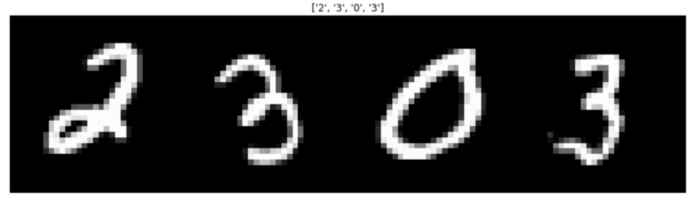

## 4.1 Batch Normalization — 1D

В этом разделе мы построим полностью связанную нейронную сеть (DNN) для классификации данных MNIST вместо использования CNN. Основная цель использования DNN - объяснить, как работает пакетная нормализация в случае одномерного ввода, такого как массив. Прежде чем передать в сеть изображения MNIST размером 28x28, мы сглаживаем их в одномерный входной массив размером 784.

In [3]:
class MyNet(nn.Module):
    def __init__(self): 
        super(MyNet, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),  # 28 x 28 = 784 превращаем входное изображение в вектор
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x
        
class MyNetBN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(784, 48),
            nn.BatchNorm1d(48), #Использование batch norm
            nn.ReLU(),
            nn.Linear(48, 24),
            nn.BatchNorm1d(24),
            nn.ReLU(),
            nn.Linear(24, 10)
        )
             
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Мы создадим две глубокие нейронные сети с тремя полностью связанными линейными слоями и чередующейся активацией ReLU между ними. В случае сети с пакетной нормализацией мы применим пакетную нормализацию до ReLU, как указано в исходной статье. Поскольку наш вход представляет собой одномерный массив, мы будем использовать класс [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), присутствующий в модуле Pytorch nn.

In [4]:
nn.BatchNorm1d(48) #48 соответсвует количеству фич подаваемых с предыдущего слоя

BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

Чтобы лучше понять, как пакетная нормализация помогает ускорить обучение сети, мы рассмотрим распределение значений по нескольким скрытым слоям в сети на этапе обучения.

Для согласованности мы построим график вывода второго линейного уровня из двух сетей и сравним распределения вывода этого уровня по сетям. Результаты выглядят так(верхняя строка соответствует случаю первой эпохи, нижняя - второй эпохе):

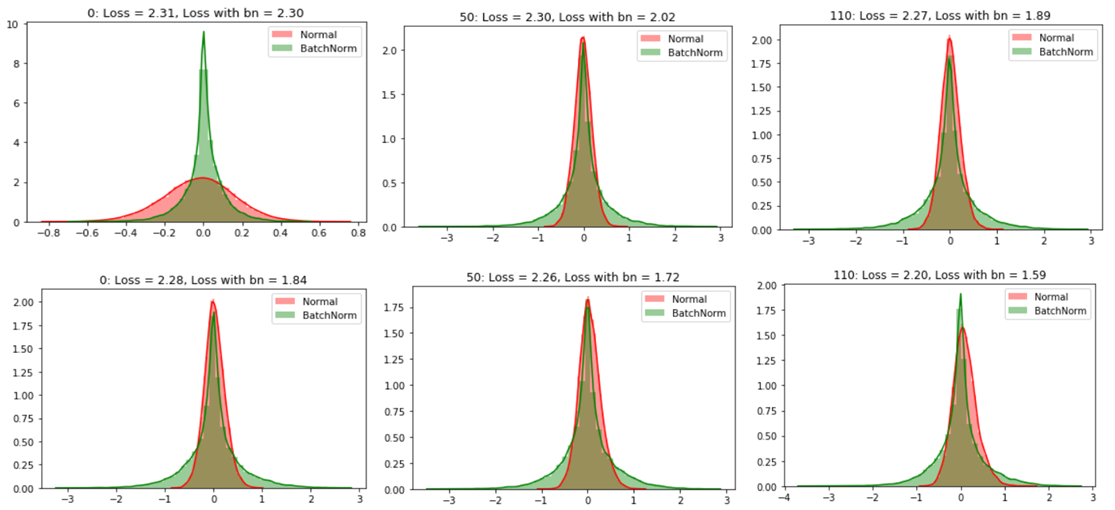

Из графиков можно сделать вывод, что распределение значений без пакетной нормализации значительно изменилось между итерациями входных данных в каждую эпоху, что означает, что последующие уровни в сети без пакетной нормализации видят различное распределение входных данных. Но изменение распределения значений для модели с пакетной нормализацией кажется незначительным.

Кроме того, мы можем видеть, что потери в сети при пакетной нормализации уменьшаются намного быстрее, чем в обычной сети, из-за ковариационного сдвига, то есть… сдвига скрытых значений для каждого пакета входных данных. Это помогает ускорить сходимость сети и сокращает время обучения.

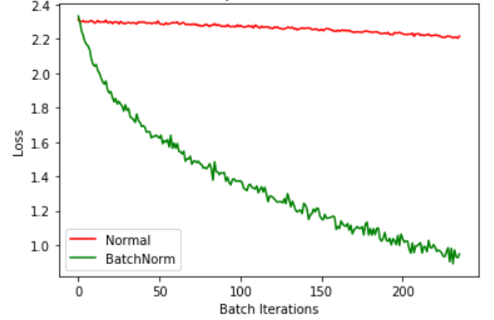

## 4.2 Batch Normalization — 2D

В предыдущем разделе мы увидели, как написать пакетную нормализацию между линейными слоями для нейронных сетей с прямой связью, которые принимают одномерный массив в качестве входных данных. В этом разделе мы обсудим, как реализовать пакетную нормализацию для сверточных нейронных сетей.

In [6]:
class CNN_BN(nn.Module):
    def __init__(self): 
        super(MyNetBN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 3, 5),         # (N, 1, 28, 28) -> (N,  3, 24, 24)
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2),  # (N, 3, 24, 24) -> (N,  3, 12, 12)
            nn.Conv2d(3, 6, 3),
            nn.BatchNorm2d(6)           # (N, 3, 12, 12) -> (N,  6, 10, 10) 
        )
        self.features1 = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(2, stride=2)   # (N, 6, 10, 10) -> (N,  6, 5, 5)
        )
        self.classifier = nn.Sequential(
            nn.Linear(150, 25),         # (N, 150) -> (N, 25)
            nn.ReLU(),
            nn.Linear(25,10)            # (N, 25) -> (N, 10)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.features1(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

Мы возьмем те же изображения данных MNIST и напишем сеть, которая реализует пакетную нормализацию. Батч изображений RGB имеет четыре измерения - размер пакета x каналы x высота x ширина. В случае изображений мы нормализуем батч по каждому каналу. Класс BatchNorm2d применяет пакетную нормализацию к 4D входу (мини-батч 2D входов с дополнительным размером канала).

Класс [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) принимает в качестве параметра количество каналов, которые он получает из выходных данных предыдущего слоя.

# 5. Dropout

В этом разделе мы обсудим концепцию dropout(отсева) в нейронных сетях, в частности, как это помогает уменьшить ошибку переобучения. После этого мы реализуем нейронную сеть с dropout и без него, чтобы увидеть, как отсев влияет на производительность сети с использованием Pytorch.

Dropout - это метод регуляризации, который случайным образом «деактивирует» несколько нейронов в нейронной сети, чтобы избежать проблемы переобучения.

## 5.1 Основная Идея

Обучение одной глубокой нейронной сети с большими параметрами данных может привести к переобучению. Можем ли мы обучить несколько нейронных сетей с разными конфигурациями на одном наборе данных и взять среднее значение этих прогнозов?

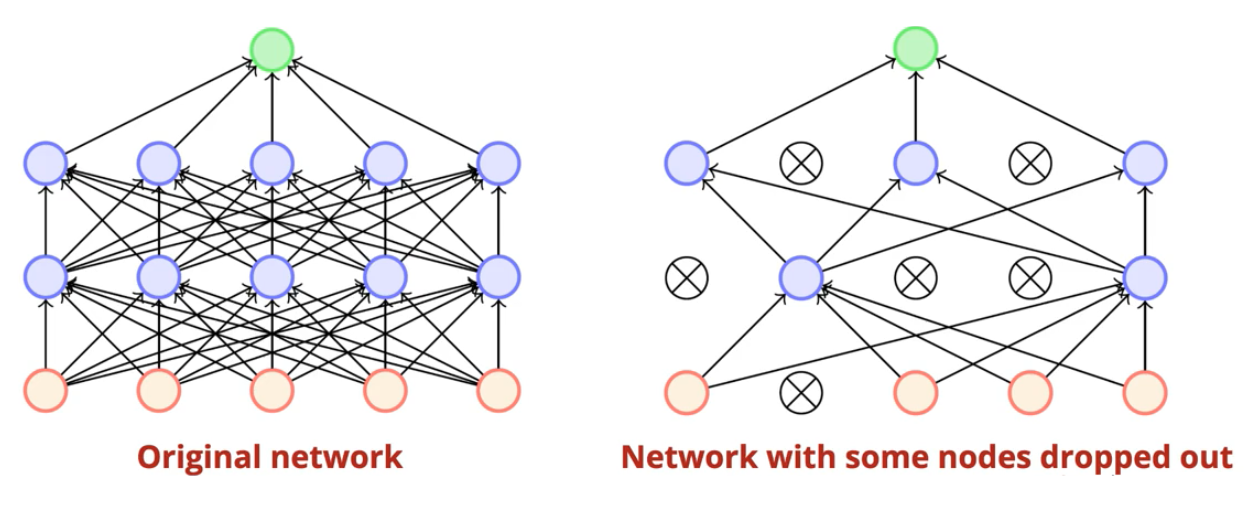

Dropout деактивирует нейроны случайным образом на каждом шаге обучения, вместо того, чтобы обучать данные в исходной сети, мы обучаем данные в сети с выпавшими узлами. На следующей итерации шага обучения скрытые нейроны, которые деактивируются при выпадении, изменяются из-за его вероятностного поведения. Таким образом, применяя отсев, то есть… деактивируя определенные отдельные узлы случайным образом во время обучения, мы можем моделировать ансамбль нейронной сети с различными архитектурами.

## 5.2 Dropout во время обучения

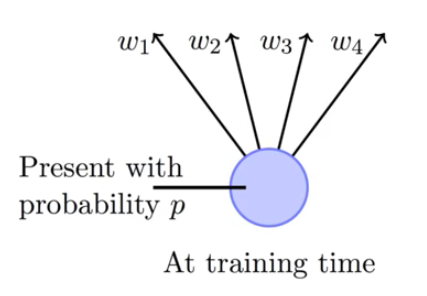

В каждой итерации обучения каждый узел в сети связан с вероятностью p, оставить ли его в сети или деактивировать из сети с вероятностью 1-p. Это означает, что веса, связанные с узлами, обновлялись только p долю раз, потому что узлы активны только p раз во время обучения.

## 5.3 Dropout во время тестирования

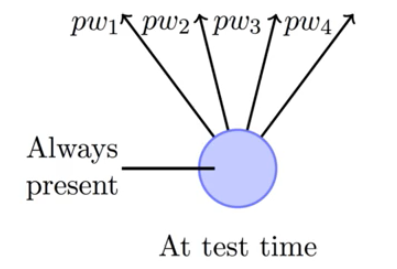

Во время тестирования мы рассматриваем исходную нейронную сеть со всеми присутствующими активациями и масштабируем выход каждого узла на значение p. Поскольку каждый узел активируется только p раз.

## 5.4 Dropout в pytorch

Для того, чтобы представить себе, как dropout уменьшает переобучение нейронной сети, мы будем генерировать простые случайные точки данных с использованием [torch.unsqueeze](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html). Полезность dropout лучше всего проявляется на пользовательских данных, которые потенциально могут переобучиться.

In [8]:
N = 50 #number of data points
noise = 0.3

#generate the train data
X_train = torch.unsqueeze(torch.linspace(-1, 1, N),1)
Y_train = X_train + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

#generate the test data
X_test = torch.unsqueeze(torch.linspace(-1,1,N),1)
Y_test = X_test + noise * torch.normal(torch.zeros(N,1), torch.ones(N,1))

После генерации данных мы можем визуализировать тензоры, используя график рассеяния matplotlib, как показано ниже:

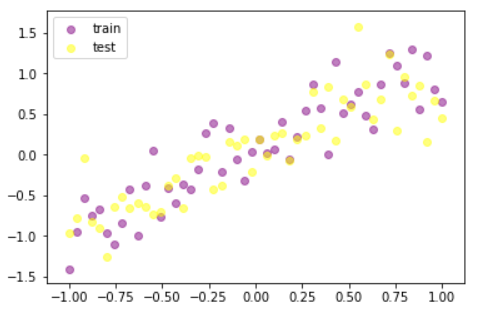

Чтобы показать эфект переобучения, мы возьмем две обученные сети - одну без dropout, а другую с dropout. Сеть без dropout имеет 3 полностью связанных скрытых слоя с ReLU в качестве функции активации для скрытых слоев, а сеть с dropout также имеет аналогичную архитектуру, но с dropout, применяемым после первого и второго линейных слоев.

In [9]:

#create a neural network with out dropout
N_h = 100 #hidden nodes

model = torch.nn.Sequential(
    nn.Linear(1, N_h),
    nn.ReLU(),
    nn.Linear(N_h, N_h),
    nn.ReLU(),
    nn.Linear(N_h, 1)
)

#create a network with dropout
model_dropout = nn.Sequential(
    nn.Linear(1, N_h),
    nn.Dropout(0.5), #50 % probability 
    nn.ReLU(),
    torch.nn.Linear(N_h, N_h),
    torch.nn.Dropout(0.2), #20% probability
    torch.nn.ReLU(),
    torch.nn.Linear(N_h, 1),
)

В Pytorch мы можем применить dropout с помощью модуля torch.nn:

In [10]:
nn.Dropout(0.5)

Dropout(p=0.5, inplace=False)

В этом примере использовали долю выпадения для dropout 0,5 после первого линейного слоя и 0,2 после второго линейного слоя. Посмотрим на результаты тестов этих двух сетей:

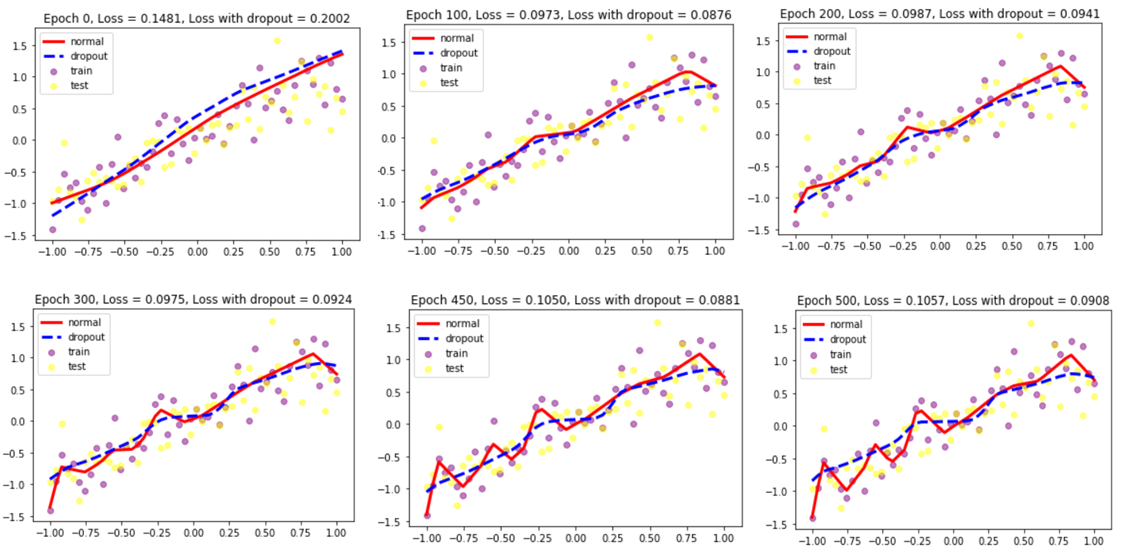

Из приведенных выше графиков мы можем сделать вывод, что по мере увеличения количества эпох модель без dropout переоценивает данные. Модель без dropout изучает шум, связанный с данными, а не обобщает данные. Мы можем видеть, что потери, связанные с моделью без dropout, увеличиваются по мере увеличения количества эпох, в отличие от потерь, связанных с моделью с dropout.

# 6. LayerNorm

В то время как батч нормализация нормализует входные данные по размерам пакета, нормализация слоя нормализует входные данные по картам признаков. Экспериментальные результаты показывают, что он хорошо работает с RNN.

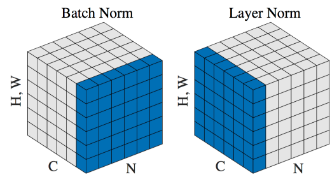

Нормализация слоев - это более простой метод нормализации, который работает с более широким диапазоном настроек. Нормализация слоев преобразует входные данные, чтобы получить нулевое среднее значение и единичную дисперсию по функциям. Обратите внимание, что пакетная нормализация фиксирует нулевое среднее и единичную дисперсию для каждого элемента. Нормализация слоев делает это для каждого пакета по всем элементам.

Нормализация слоев обычно используется для задач НЛП.

### Пример:

использовать [LayerNorm](https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.html) так же можно из torch.nn:

In [ ]:
nn.LayerNorm(64) # 64 - количетсво признаков с прошлого слоя

In [12]:
input = torch.randn(20, 5, 10, 10)

C обучающимися параметрами:

In [17]:
nn.LayerNorm(input.size())

LayerNorm((20, 5, 10, 10), eps=1e-05, elementwise_affine=True)

Без них:

In [18]:
nn.LayerNorm(input.size()[1:], elementwise_affine=False)

LayerNorm((5, 10, 10), eps=1e-05, elementwise_affine=False)

Нормализация по двум последним измерениям:

In [20]:
nn.LayerNorm([10, 10])

LayerNorm((10, 10), eps=1e-05, elementwise_affine=True)

По последнему измерению:

In [21]:
nn.LayerNorm(10)

LayerNorm((10,), eps=1e-05, elementwise_affine=True)